In [1]:
import scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os
import pandas as pd, seaborn as sns, argparse, pyemma as py, pickle, copy
import mdtraj as md
from scipy.stats import binned_statistic_2d as bins2d

sys.path.insert(1, '../msms/')
from utils import * 

Using TensorFlow backend.


In [2]:
def score_side_contacts(dists, base, seq, AT_cutoff=0.7, GC_cutoff=0.65):
    '''only look at naive contacts using conistent scroing -- no out-of-register'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    dists = np.concatenate(dists)
    wc_sum = len(seq) - 1
        
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        bidx = int(base.replace('b', ''))
        del s1_bps[bidx-1]
    else:
        bidx = 0
        
    # find indexes for bps on the 5' and 3' side of the duplex
    if base in ['b2', 'b4']: prime5_max = 4
    else: prime5_max = 5

    idx = 0
    AT_nat_5p, GC_nat_5p = [], []
    AT_nat_3p, GC_nat_3p = [], []
    for i, b1 in enumerate(s1_bps):
        if bidx > 0 and i > bidx-2: wc_sum = len(seq) - 2
        for j, b2 in enumerate(s2_bps):
            if i+j==wc_sum and b1+b2 in ['AT', 'TA']:
                if i < prime5_max:
                    AT_nat_5p.append(idx)
                elif i > len(s1_bps)-6:
                    AT_nat_3p.append(idx)
            elif i+j==wc_sum and b1+b2 in ['GC', 'CG']:
                if i < prime5_max:
                    GC_nat_5p.append(idx)
                elif i > len(s1_bps)-6:
                    GC_nat_3p.append(idx)
            idx+=1
    
    # sum native pairs on 5' side
    AT_prime5 = np.sum((dists[:, AT_nat_5p] < AT_cutoff), axis=1)
    GC_prime5 = np.sum((dists[:, GC_nat_5p] < GC_cutoff), axis=1)
    all_prime5 = AT_prime5 + GC_prime5
    
    # sum native pairs on 3' side
    AT_prime3 = np.sum((dists[:, AT_nat_3p] < AT_cutoff), axis=1)
    GC_prime3 = np.sum((dists[:, GC_nat_3p] < GC_cutoff), axis=1)
    all_prime3 = AT_prime3 + GC_prime3
    
    #print(max(all_prime5), max(all_prime3))
    return all_prime5, all_prime3

In [3]:
def get_all_wcs(num_bp, b_idx, strand=1):
    '''return idxs of all available pairs for a given abasic'''
    
    wc_list = []
    diag_list = []
    strand1 = [i for i in np.arange(num_bp)]
    strand2 = [i for i in np.arange(num_bp)]
    
    if b_idx > 0:
        strand1 = strand1[:b_idx-1] + strand1[b_idx:] 
        
    idx = 0
    for b1 in strand1:
        for b2 in strand2:
            if b1 + b2 == num_bp-1:
                wc_list.append(idx)
            if b1 == b2:
                diag_list.append(idx)
            idx+= 1
            
    return wc_list, diag_list

def get_temp(seq, base):
    '''look up temperature in corresponding seq/base dist file'''
    
    path = f'../abasic_dists/{seq}_msm_add-Tms/{base}*'
    path = glob.glob(path)[0]
    temp = int(path.split('T-')[-1][:3])
    return temp

def nbps_fes(nbps, temp):
    '''generate fes from discrete probability density'''
    
    kb = 8.3124 / 1000
    prob_hist, bins = np.histogram(nbps, bins=12, range=(0, 12))
    fes_hist = -kb*temp*np.log(prob_hist)
    fes_hist = fes_hist - fes_hist[0]
    
    return bins[:-1], fes_hist
    

def score_all_contacts(dists, base, seq, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by summing all available contacts below respective cutoffs'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    dists = np.concatenate(dists)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    idx = 0
    AT_all = np.zeros(len(dists))
    GC_all = np.zeros(len(dists))
    for b1 in s1_bps:
        AT_possible, GC_possible = [], []
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
                
        AT_sums = np.sum((dists[:, AT_possible] < AT_cutoff), axis=1) > 0
        GC_sums = np.sum((dists[:, GC_possible] < GC_cutoff), axis=1) > 0
        AT_all += AT_sums
        GC_all += GC_sums
        
    all_sums = AT_all + GC_all       
    return all_sums, AT_all, GC_all


def score_native_contacts(dists, base, seq, AT_cutoff=0.7, GC_cutoff=0.65):
    '''only look at naive contacts using conistent scroing'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    dists = np.concatenate(dists)
    wc_sum = len(seq) - 1
        
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        bidx = int(base.replace('b', ''))
        del s1_bps[bidx-1]
    else:
        bidx = 0

    idx = 0
    AT_nat, GC_nat = [], []
    for i, b1 in enumerate(s1_bps):
        if bidx > 0 and i > bidx-2: wc_sum = len(seq) - 2
        for j, b2 in enumerate(s2_bps):
            if i+j==wc_sum and b1+b2 in ['AT', 'TA']:
                AT_nat.append(idx)
            elif i+j==wc_sum and b1+b2 in ['GC', 'CG']:
                GC_nat.append(idx)
            idx+=1
                
    AT_sums = np.sum((dists[:, AT_nat] < AT_cutoff), axis=1)
    GC_sums = np.sum((dists[:, GC_nat] < GC_cutoff), axis=1) 
    all_sums = AT_sums + GC_sums    
            
    return all_sums

def score_side_contacts(dists, base, seq, AT_cutoff=0.7, GC_cutoff=0.65):
    '''only look at naive contacts using conistent scroing -- includes out of register'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    dists = np.concatenate(dists)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]
        
    # find indexes for bps on the 5' and 3' side of the duplex
    if base in ['b2', 'b4']: prime5 = s1_bps[:4]
    else: prime5 = s1_bps[:5]
    prime3 = s1_bps[-5:]
    
    #print(seq, base, prime5, prime3)

    idx = 0
    AT_all, GC_all = np.zeros(len(dists)), np.zeros(len(dists))
    for b1 in prime5:
        AT_possible, GC_possible = [], []
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
        
        #print(b1, AT_possible, GC_possible)
                
        AT_sums = np.sum((dists[:, AT_possible] < AT_cutoff), axis=1) > 0
        GC_sums = np.sum((dists[:, GC_possible] < GC_cutoff), axis=1) > 0
        AT_all += AT_sums
        GC_all += GC_sums  
    left_sums = AT_all + GC_all
    
    # skip all middle contact idxs (unless b6 sequence)
    if base != 'b6':  idx += len(seq)
    
    AT_all, GC_all = np.zeros(len(dists)), np.zeros(len(dists))
    for b1 in prime3:
        AT_possible, GC_possible = [], []
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
                
        AT_sums = np.sum((dists[:, AT_possible] < AT_cutoff), axis=1) > 0
        GC_sums = np.sum((dists[:, GC_possible] < GC_cutoff), axis=1) > 0
        AT_all += AT_sums
        GC_all += GC_sums
    right_sums = AT_all + GC_all
    
    return left_sums, right_sums


def get_microstate_coords(cv1, cv2, dtraj):
    '''return average committor value for a given set of 2D coordinates'''
    
    micro_avgs = []
    for i in range(max(dtraj)+1):
        micro_idxs = np.where(dtraj==i)
        cv1_avg, cv2_avg = np.mean(cv1[micro_idxs]), np.mean(cv2[micro_idxs])
        micro_avgs.append([cv1_avg, cv2_avg])
    
    return np.array(micro_avgs)

# functions return continous CV data
def fray_up_dists(equ_dists):
    return 1/np.mean(equ_dists[:, wc_idxs[[0, 1, 2]]], axis=1)

def fray_down_dists(equ_dists):
    return 1/np.mean(equ_dists[:, wc_idxs[[-5, -3, -1]]], axis=1)

def fray_core_dists(equ_dists):
    return 1/np.mean(equ_dists[:, wc_idxs[[2, -5]]], axis=1)

def fray_both_dists(equ_dists):
    return 1/np.mean(equ_dists[:, wc_idxs[[0, 1, -3, -1]]], axis=1)

print(get_all_wcs(11, 0))
print(get_all_wcs(11, 2))

#score = score_all_contacts(equ_dists, base)
#print(score.shape, score.mean())scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os


([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])
([10, 19, 29, 39, 49, 59, 69, 79, 89, 99], [0, 13, 25, 37, 49, 61, 73, 85, 97, 109])


In [4]:
num_bp = 11
lag = 1
pstride = 1
bp_cutoff = 0.8
kb = 8.3124 / 1000

seq_list = ['TTTTTTTTTTT', 'CGCATATATAT', 'CCTATATATCC', 'TATAGCGATAT']
cmap_dict = {'TTTTTTTTTTT':'Greys', 'CGCATATATAT':'Greens', 
               'CCTATATATCC':'Purples', 'TATAGCGATAT':'Reds'}
base_idxs = [0, 2, 4, 6]
base_list = ['control', 'b2', 'b4', 'b6']
wc_idxs = np.array([10,19,28,37,47,57,67,77])

n_trajs = 25
max_frames = 100000


def plot_tpt_cont(x_f, y_f, hrange, lag=4, nbins = 10, save_path=None, plot_its=False):
    '''build msm on a give 2d continous basis and perform tpt'''
    

    fig, axes = plt.subplots(4, 4, figsize=(24, 20))

    for seq, ax_row in zip(seq_list, axes.T):

        #for base, bidx, ax in zip(base_list,base_idxs,ax_row):
        for base, bidx, ax in zip(base_list, base_idxs, ax_row):

            # load from dists files directly
            #print(seq, base)
            dists_path = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}_*')[0]
            temp = int(dists_path.split('_T-')[-1][:3])
            equ_dists = np.load(dists_path)[:, -max_frames:, :]
            #print('loaded dists  ', equ_dists.shape)
            
            # isolate only the shared features
            common_idxs = translate_pairs(11, base)
            equ_dists = np.concatenate(equ_dists)[::pstride, common_idxs]

            # get discrete clusters via histogramming
            x, y = x_f(equ_dists), y_f(equ_dists)
            _, xedges, yedges = np.histogram2d(x, y, bins=nbins, range=hrange)
            xd = np.digitize(x, xedges) #- 1
            yd = np.digitize(y, yedges) #- 1
            
            dtraj = nbins*xd + yd
            h, _ = np.histogram(dtraj, bins=nbins*nbins)
            empty_states = np.where(h==0)[0]
            
            # show its only
            if plot_its:
                its = py.msm.its(dtraj, lags=50, nits=5)
                py.plots.plot_implied_timescales(its, ax=ax)

                if base=='control': abasic_label= seq
                else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
                ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
                continue

            # estimate MSM
            msm = py.msm.estimate_markov_model([t for t in dtraj.reshape(n_trajs, max_frames)], lag)
            nstates = len(msm.stationary_distribution)
            A, B = [0], [nstates - 1]  

            # find all paths and fluxes from top to bottom corner     
            tpt = py.msm.tpt(msm, A, B)
            net_flux = tpt.net_flux
            #print(net_flux.shape)
            
            (paths, pathfluxes) = tpt.pathways(fraction=0.95)
            #print(len(np.unique(dtraj)), len(paths))

            # track flux through all paths:
            total_flux = np.zeros(nstates)
            for path, pflux in zip(paths, pathfluxes):
                total_flux[path] += pflux

            # normalize density:
            total_flux = total_flux / np.max(total_flux[1:-1])

            # account for any missing states
            for s in empty_states:  
                total_flux = np.insert(total_flux, s, 0)
            total_flux = total_flux.reshape(nbins, nbins)
            
            # try to quantify differences in flux from side to side
            sum_flux1 = np.sum(total_flux[:-nbins//2, nbins//2:])
            sum_flux2 = np.sum(total_flux[nbins//2:, :-nbins//2])
            flux_ratio = sum_flux1 / (sum_flux1 + sum_flux2)
            #print(sum_flux1, sum_flux2, flux_ratio)

            # heatmap of path counts
            xlab = [str(np.round(x, 1)) for x in xedges[:-1]]
            ylab = [str(np.round(y, 1)) for y in yedges[:-1]]
            mask = np.zeros((nbins, nbins))
            #mask[0, 0] = mask[-1, -1] = 1
            sns.heatmap(total_flux.reshape(nbins, nbins), mask = mask, cmap=cmap_dict[seq], 
                        xticklabels=xlab, yticklabels=ylab, ax=ax)

            # plot a 2D putative CV landscape
            if base=='control': abasic_label= seq
            else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
            ax.set_title(f"{abasic_label}  3'ratio = {np.round(100*flux_ratio, 1)}%")
            
            # save relaxation arrays 
            if save_path is not None:
                np.save(f'{save_path}/continous-{seq}_{base}_lag-{lag}.npy', total_flux)
            
            #break
        #break
        
    spaces = ' '*45
    axes[2, 0].set_ylabel(spaces+r'$d_{abasic}^{-1}$ (nm$^{-1}$)' + '\n', fontsize=20)
    axes[-1, 1].set_xlabel(spaces+r'$d_{intact}^{-1}$ (nm$^{-1}$)' + '\n', fontsize=20)
    
    
def plot_tpt_ATGC(lag=4, pad=0.1, save_path=None, plot_its=False):
    '''build msm on discrete base pairing coorinate and perform tpt'''
    

    fig, axes = plt.subplots(4, 4, figsize=(24, 20))

    for seq, ax_row in zip(seq_list, axes.T):

        #for base, bidx, ax in zip(base_list,base_idxs,ax_row):
        for base, bidx, ax in zip(base_list, base_idxs, ax_row):

            # load from dists files directly
            #print(seq, base)
            dists_path = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}_*')[0]
            temp = int(dists_path.split('_T-')[-1][:3])
            equ_dists = np.load(dists_path)[:, -max_frames:, :]
            #print('loaded dists  ', equ_dists.shape)
            
            # get all wc pairs for nbps plots:
            n_bp = len(seq)
            _, AT_sum, GC_sum = score_all_contacts(equ_dists, base, seq, AT_cutoff=0.6+pad, GC_cutoff=0.55+pad)
            #print(np.min(AT_sum))

            AT_d = np.digitize(AT_sum, np.arange(1, np.max(AT_sum)+1)) #np.digitize(AT_sum, AT_edges)
            GC_d = np.digitize(GC_sum, np.arange(1, np.max(GC_sum)+1)) #np.digitize(GC_sum, GC_edges)
            #print(np.max(AT_d), np.max(GC_d), np.min(AT_d), np.min(GC_d))
            
            dtraj = (n_bp+1)*AT_d + GC_d
            h, _ = np.histogram(dtraj, bins=(n_bp+1)*(n_bp+1), range=(-.5, (n_bp+1)*(n_bp+1)-.5))
            empty_states = np.where(h==0)[0]
            
            # show its only
            if plot_its:
                its = py.msm.its(dtraj, lags=50, nits=5)
                py.plots.plot_implied_timescales(its, ax=ax)

                if base=='control': abasic_label= seq
                else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
                ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
                continue

            # estimate MSM
            msm = py.msm.estimate_markov_model([t for t in dtraj.reshape(n_trajs, max_frames)], lag)
            nstates = len(msm.stationary_distribution)
            A, B = [0], [len(msm.stationary_distribution) -1] 

            # find all paths and fluxes from top to bottom corner     
            tpt = py.msm.tpt(msm, A, B)
            net_flux = tpt.net_flux
            (paths, pathfluxes) = tpt.pathways(fraction=0.99)
            #print(len(np.unique(dtraj)), len(paths))

            # track flux through all paths:
            total_flux = np.zeros(nstates)
            for path, pflux in zip(paths, pathfluxes):
                total_flux[path] += pflux

            # normalize density:
            total_flux = total_flux / np.max(total_flux)

            # account for any missing states
            mask = np.zeros(nstates)
            for s in empty_states:  
                total_flux = np.insert(total_flux, s, 0)
                mask = np.insert(mask, s, 1)
            total_flux = total_flux.reshape(n_bp+1, n_bp+1)
            mask = mask.reshape(n_bp+1, n_bp+1)
            

            # heatmap of path counts
            xlab = ylab = [i for i in range(n_bp+1)]
            #mask[0, 0] = mask[-1, -1] = 1
            sns.heatmap(total_flux, mask = mask, cmap=cmap_dict[seq], 
                        xticklabels=xlab, yticklabels=ylab, ax=ax)

            # plot a 2D putative CV landscape
            if base=='control': abasic_label= seq
            else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
            ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
            
            # save relaxation arrays 
            if save_path is not None:
                np.save(f'{save_path}/ATGC-{seq}_{base}_lag-{lag}.npy', total_flux)
            
            #break
        #break
        
    spaces = ' '*50
    axes[2, 0].set_ylabel(spaces+r'N AT pairs' + '\n', fontsize=20)
    axes[-1, 1].set_xlabel(spaces+r'N GC pairs'+ '\n', fontsize=20)
    axes[0, 1].set_title(spaces+f'lag={lag}   pad={pad}'+ '\n', fontsize=20)
    
    #return total_flux
    
def plot_tpt_shifted(lag=4, pad=0.1, save_path=None, plot_its=False):
    '''build msm on discrete base pairing coorinate and perform tpt'''
    

    fig, axes = plt.subplots(4, 4, figsize=(24, 20))

    for seq, ax_row in zip(seq_list, axes.T):

        #for base, bidx, ax in zip(base_list,base_idxs,ax_row):
        for base, bidx, ax in zip(base_list, base_idxs, ax_row):

            # load from dists files directly
            #print(seq, base)
            dists_path = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}_*')[0]
            temp = int(dists_path.split('_T-')[-1][:3])
            equ_dists = np.load(dists_path)[:, -max_frames:, :]
            #print('loaded dists  ', equ_dists.shape)
            
            # get all contacts and native contacts
            n_bp = len(seq)
            all_sum, _, _ = score_all_contacts(equ_dists, base, seq, AT_cutoff=0.6+pad, GC_cutoff=0.55+pad)
            nat_sum = score_native_contacts(equ_dists, base, seq, AT_cutoff=0.6+pad, GC_cutoff=0.55+pad)

            all_d = np.digitize(all_sum, np.arange(1, np.max(all_sum)+1)) #np.digitize(AT_sum, AT_edges)
            nat_d = np.digitize(nat_sum, np.arange(1, np.max(nat_sum)+1)) #np.digitize(GC_sum, GC_edges)
            
            dtraj = (n_bp+1)*all_d + nat_d
            h, _ = np.histogram(dtraj, bins=(n_bp+1)*(n_bp+1), range=(-.5, (n_bp+1)*(n_bp+1)-.5))
            empty_states = np.where(h==0)[0]
            
            # show its only
            if plot_its:
                its = py.msm.its(dtraj, lags=50, nits=5)
                py.plots.plot_implied_timescales(its, ax=ax)

                if base=='control': abasic_label= seq
                else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
                ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
                continue

            # estimate MSM
            msm = py.msm.estimate_markov_model([t for t in dtraj.reshape(n_trajs, max_frames)], lag)
            nstates = len(msm.stationary_distribution)
            A, B = [0], [len(msm.stationary_distribution) -1] 

            # find all paths and fluxes from top to bottom corner     
            tpt = py.msm.tpt(msm, A, B)
            net_flux = tpt.net_flux
            (paths, pathfluxes) = tpt.pathways(fraction=0.99)
            #print(len(np.unique(dtraj)), len(paths))

            # track flux through all paths:
            total_flux = np.zeros(nstates)
            for path, pflux in zip(paths, pathfluxes):
                total_flux[path] += pflux

            # normalize density:
            total_flux = total_flux / np.max(total_flux)

            # account for any missing states
            mask = np.zeros(nstates)
            for s in empty_states:  
                total_flux = np.insert(total_flux, s, 0)
                mask = np.insert(mask, s, 1)
            total_flux = total_flux.reshape(n_bp+1, n_bp+1)
            mask = mask.reshape(n_bp+1, n_bp+1)

            # heatmap of path counts
            xlab = ylab = [i for i in range(n_bp+1)]
            #mask[0, 0] = mask[-1, -1] = 1
            sns.heatmap(total_flux, mask = mask, cmap=cmap_dict[seq], 
                        xticklabels=xlab, yticklabels=ylab, ax=ax)

            # plot a 2D putative CV landscape
            if base=='control': abasic_label= seq
            else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
            ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
            
            # save relaxation arrays 
            if save_path is not None:
                np.save(f'{save_path}/shifted-{seq}_{base}_lag-{lag}.npy', total_flux)
            
            #break
        #break
        
    spaces = ' '*50
    axes[2, 0].set_ylabel(spaces+r'N total pairs' + '\n', fontsize=20)
    axes[-1, 1].set_xlabel(spaces+r'N native pairs'+ '\n', fontsize=20)
    axes[0, 1].set_title(spaces+f'lag={lag}   pad={pad}'+ '\n', fontsize=20)
    
    #return total_flux
    
    
def plot_tpt_sides(lag=1, pad=0.1, save_data=None, save_figs=None, 
                   plot_commit=False, plot_its=False, n_path=None):
    '''build msm on discrete base pairing coorinate and perform tpt'''
    
    if n_path is None:
        fig, axes = plt.subplots(4, 4, figsize=(24, 20))
    else:
        fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    for seq, ax_row in zip(seq_list, axes.T):

        #for base, bidx, ax in zip(base_list,base_idxs,ax_row):
        for base, bidx, ax in zip(base_list, base_idxs, ax_row):

            # load from dists files directly
            #print(seq, base)
            dists_path = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}_*')[0]
            temp = int(dists_path.split('_T-')[-1][:3])
            equ_dists = np.load(dists_path)[:, -max_frames:, :]
            #print('loaded dists  ', equ_dists.shape)
            
            # get all contacts ￼and native contacts
            n_bp = len(seq)
            all_sum, nat_sum = score_side_contacts(equ_dists, base, seq, AT_cutoff=0.6+pad, GC_cutoff=0.55+pad)

            all_d = np.digitize(all_sum, np.arange(1, np.max(all_sum)+1)) #np.digitize(AT_sum, AT_edges)
            nat_d = np.digitize(nat_sum, np.arange(1, np.max(nat_sum)+1)) #np.digitize(GC_sum, GC_edges)
            
            dtraj = (6)*all_d + nat_d
            h, _ = np.histogram(dtraj, bins=(6)*(6), range=(-.5, (6)*(6)-.5))
            empty_states = np.where(h==0)[0]
            
            # show its only
            if plot_its:
                its = py.msm.its(dtraj, lags=50, nits=5)
                py.plots.plot_implied_timescales(its, ax=ax)

                if base=='control': abasic_label= seq
                else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
                ax.set_title(f"{abasic_label}") # 3'ratio = {np.round(100*flux_ratio, 1)}%")
                continue

            # estimate MSM
            msm = py.msm.estimate_markov_model([t for t in dtraj.reshape(n_trajs, max_frames)], lag)
            nstates = len(msm.stationary_distribution)
            A, B = [0], [len(msm.stationary_distribution)-1] 
                
            # find all paths and flux￼es from top to bottom corner     
            tpt = py.msm.tpt(msm, A, B)
            net_flux = tpt.net_flux
            (paths, pathfluxes) = tpt.pathways(fraction=0.99)
            #print(len(np.unique(dtraj)), len(paths))
            
            # plot a 2D putative CV landscape
            if base=='control': abasic_label= seq
            else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
            xlab = ylab = [i for i in range(6)]
                
            # find committor probability in each state
            if plot_commit:
                commits = tpt.committor
                for s in empty_states:  
                    commits = np.insert(commits, s, 0)
                commits = commits.reshape(6, 6)
                sns.heatmap(commits, cmap=cmap_dict[seq], 
                    xticklabels=xlab, yticklabels=ylab, ax=ax,
                    linecolor='gray', linewidths=1)
                ax.set_title(f"{abasic_label}", fontsize=16)
                np.save(f'{save_data}/commits-{seq}_{base}_lag-{lag}.npy', commits)
                continue
                
            # track flux through all paths:
            total_flux = np.zeros(nstates)
            if n_path is None:
                for path, pflux in zip(paths, pathfluxes):
                    total_flux[path] += pflux

                # normalize density:
                total_flux = total_flux / np.max(total_flux[1:len(msm.stationary_distribution)-2])
                ax.set_title(f"{abasic_label}")
                cbar = True
                
            # look at individual paths
            else:
                total_flux[paths[n_path]] = 1
                flux_perc = 100*pathfluxes[n_path]/np.sum(pathfluxes)
                print(pathfluxes[n_path], flux_perc)
                flux_label = f'Path {n_path+1} = {np.round(flux_perc, 1)}% total flux'
                ax.set_title(f'{abasic_label}\n{flux_label}', fontsize=18)
                cbar = False

            # account for any missing states
            mask = np.zeros(nstates)
            #mask[A + B] = 1
            for s in empty_states:  
                total_flux = np.insert(total_flux, s, 0)
                mask = np.insert(mask, s, 1)
            #print(total_flux.shape)
            total_flux = total_flux.reshape(6, 6)
            mask = mask.reshape(6, 6)

            # heatmap of path counts
            #mask[0, 0] = mask[-1, -1] = 1
            sns.heatmap(total_flux, mask = mask, cmap=cmap_dict[seq], 
                        xticklabels=xlab, yticklabels=ylab, ax=ax, cbar=cbar,
                        linecolor='gray', linewidths=1)
            
            # save relaxation arrays 
            if save_data is not None and n_path is None:
                np.save(f'{save_data}/sides-{seq}_{base}_lag-{lag}.npy', total_flux)
                
            if save_data is not None and n_path is not None:
                np.save(f'{save_data}/sides-path-{n_path}_{seq}_{base}_lag-{lag}.npy', total_flux)
            
            #break
        #break
    
    if plot_commit:
        plt.savefig(f'./figs/commit_lag-{lag}.pdf', dpi=600)
        plt.savefig(f'./figs/commit_lag-{lag}.png', dpi=600) 
            
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    if save_figs is not None and n_path is not None:
        plt.savefig(f'./figs/flux_path-{n_path}_lag-{lag}.pdf', dpi=600)
        plt.savefig(f'./figs/flux_path-{n_path}_lag-{lag}.png', dpi=600)
        
    elif save_figs is not None and n_path is None:
        plt.savefig(f'./figs/flux_path-avg-mask_lag-{lag}.pdf', dpi=600)
        plt.savefig(f'./figs/flux_path-avg-mask_lag-{lag}.png', dpi=600)
        
    spaces = ' '*50
    axes[2, 0].set_ylabel(spaces+r'N 5 prime pairs' + '\n', fontsize=20)
    axes[-1, 1].set_xlabel(spaces+r'N 3 prime pairs'+ '\n', fontsize=20)
    #axes[0, 1].set_title(spaces+f'lag={lag}   pad={pad}'+ '\n', fontsize=20)
    

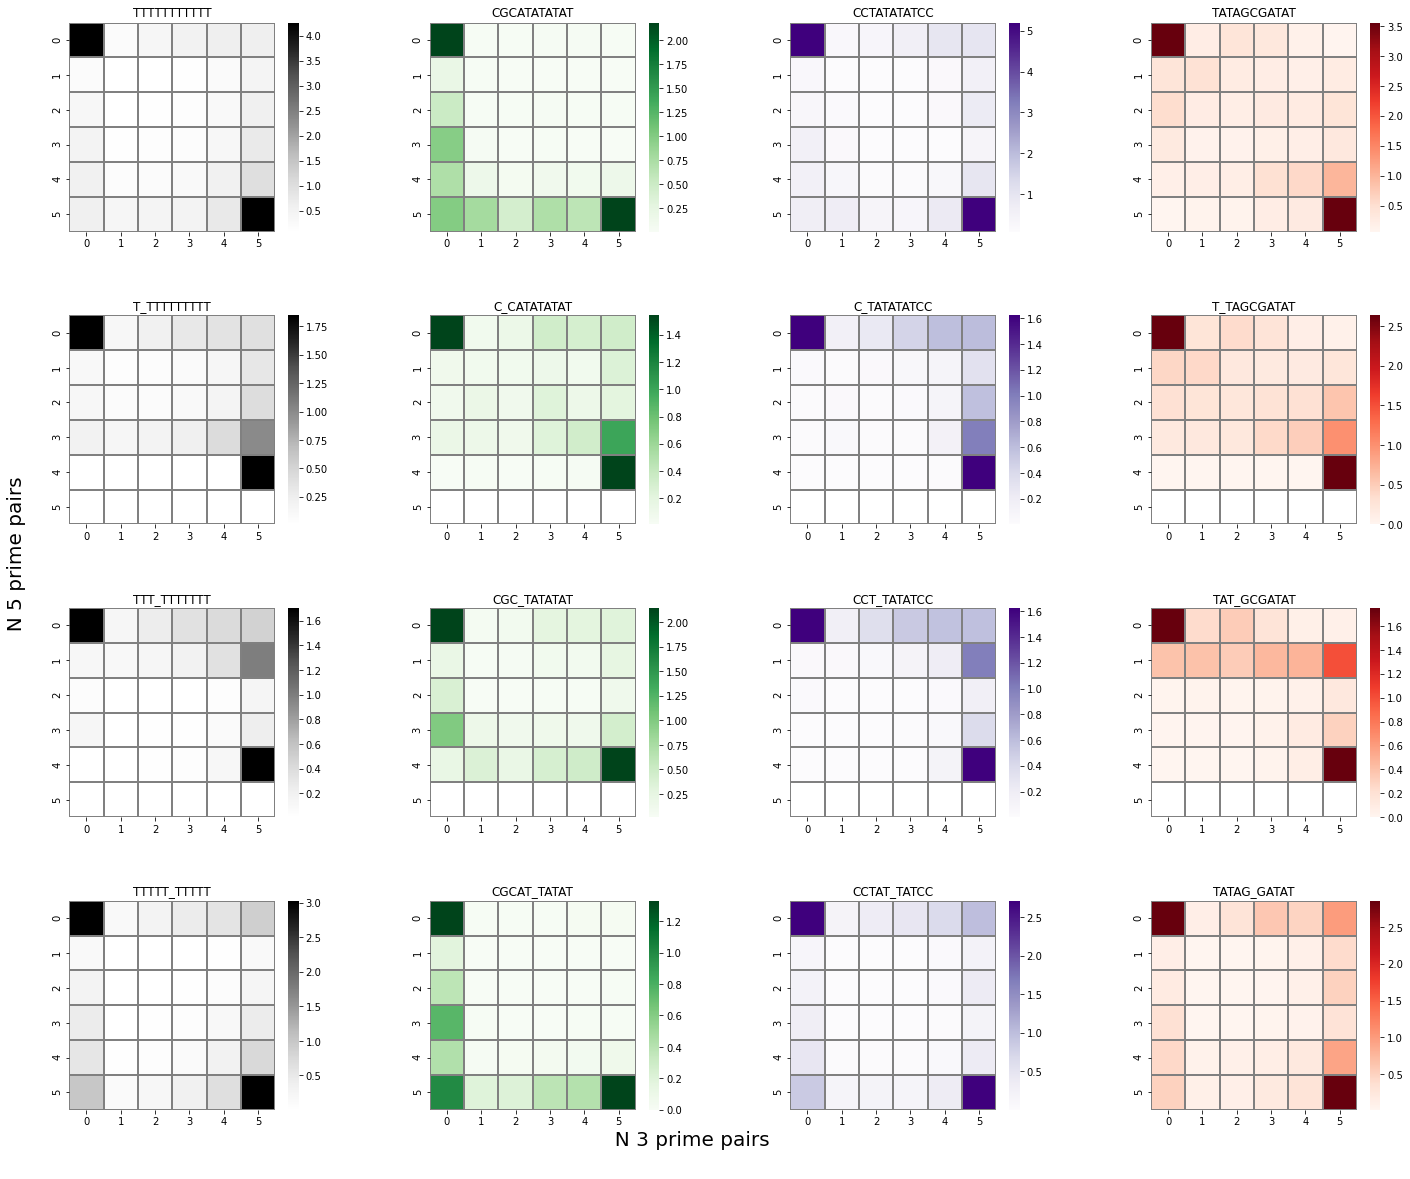

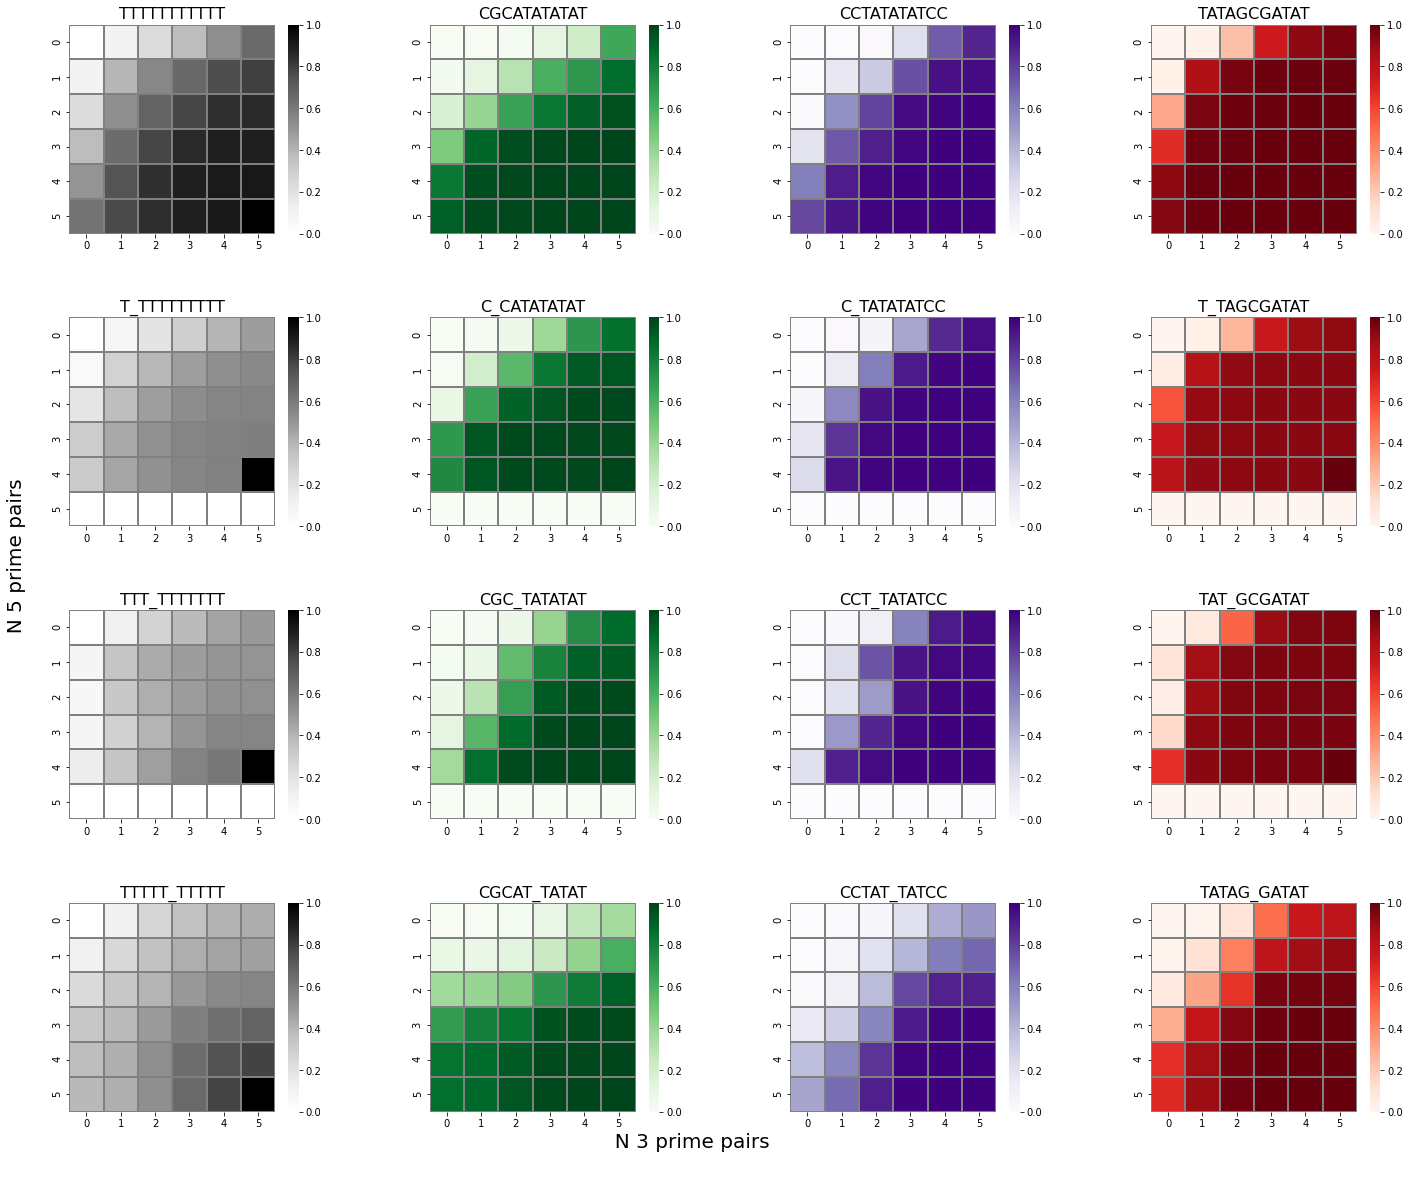

In [5]:
# test committor plots

lag, pad = 10, 0.1
#plot_tpt_sides(lag=lag, pad=pad, save_data='./save_tpt/', save_figs=None)
#plot_tpt_sides(lag=lag, pad=pad, plot_commit=True, save_data='./save_tpt/', save_figs=None)

plot_tpt_sides(lag=lag, pad=pad, save_data='./save_tpt/', save_figs=None)
plot_tpt_sides(lag=lag, pad=pad, plot_commit=True, save_data='./save_tpt/', save_figs=None)

In [ ]:
# plot most populated paths at lag 1 and 10

for lag in [1, 10]:
    for n_path in range(5):

        print(f'lag={lag}   pad={pad}')
        plot_tpt_sides(lag=lag, pad=pad, plot_its=False, 
                       save_data='./save_tpt/', save_figs='./figs/', n_path=n_path)

    plot_tpt_ATGC(lag=lag, plot_its=False, save_path='./save_tpt/')
    plot_tpt_shifted(lag=lag, plot_its=False, save_path='./save_tpt/')
        

CGCATATATAT control
loaded dists   (25, 100000, 121)


CGCATATATAT b2
loaded dists   (25, 100000, 110)


CGCATATATAT b4
loaded dists   (25, 100000, 110)


CGCATATATAT b6
loaded dists   (25, 100000, 110)


TATAGCGATAT control
loaded dists   (25, 100000, 121)


TATAGCGATAT b2
loaded dists   (25, 100000, 110)


TATAGCGATAT b4
loaded dists   (25, 100000, 110)


TATAGCGATAT b6
loaded dists   (25, 100000, 110)


CCTATATATCC control
loaded dists   (25, 100000, 121)


CCTATATATCC b2
loaded dists   (25, 100000, 110)


CCTATATATCC b4
loaded dists   (25, 100000, 110)


CCTATATATCC b6
loaded dists   (25, 100000, 110)


TTTTTTTTTTT control
loaded dists   (25, 100000, 121)


TTTTTTTTTTT b2
loaded dists   (25, 100000, 110)


TTTTTTTTTTT b4
loaded dists   (25, 100000, 110)


TTTTTTTTTTT b6
loaded dists   (25, 100000, 110)


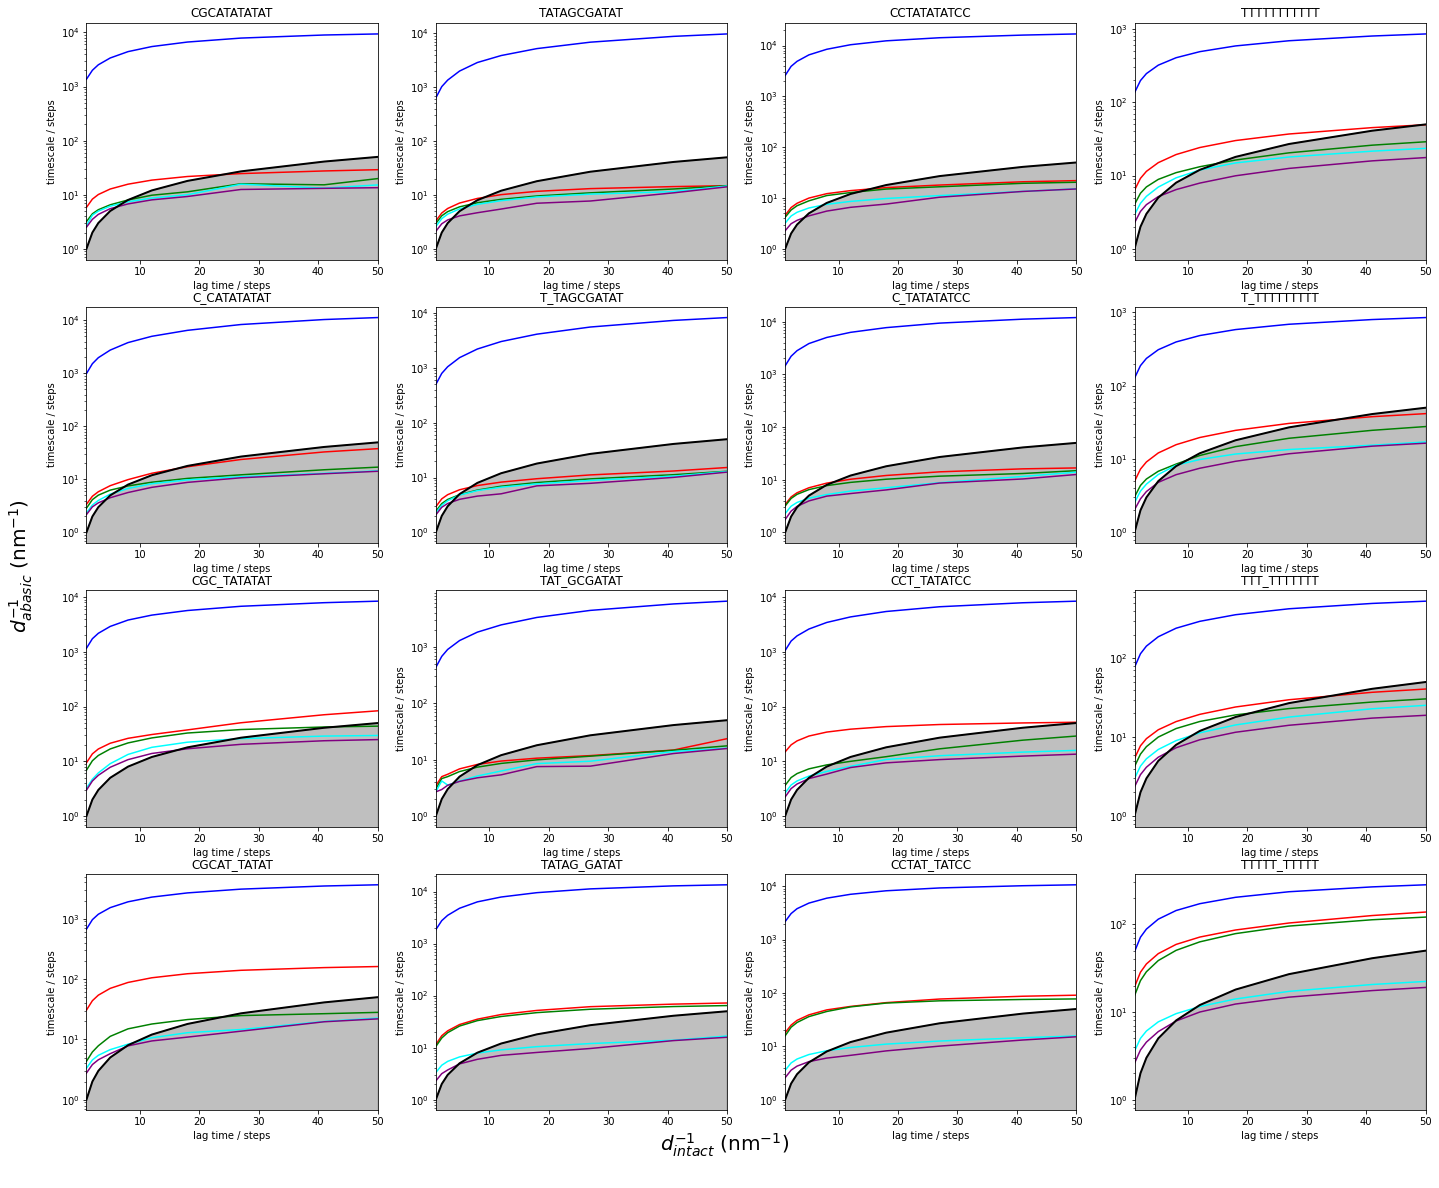

In [19]:
xmin, xmax =  0.13, 1.85
ymin, ymax =  0.13, 1.85
hrange = [[xmin, xmax], [ymin, ymax]]

for lag in [10]:
    plot_tpt_cont(fray_down_dists, fray_up_dists, hrange, lag=lag, plot_its=True)